In [7]:
import os
import time
import numpy as np
import psutil
import matplotlib.pyplot as plt
from matrix import Matrix
from qr import qr_algorithm
from better_svd import truncated_svd_power_iteration


--- Тест 1/5: Матрица 5x5, k=5 ---
Тестирование SVD...
  Время SVD: 0.0010 с | Память: 64.63 МБ (+0.10 МБ)
Тестирование QR-алгоритма...
  Время QR: 0.2788 с | Память: 64.66 МБ (+0.03 МБ)

--- Тест 2/5: Матрица 10x10, k=10 ---
Тестирование SVD...
  Время SVD: 0.0027 с | Память: 64.67 МБ (+0.00 МБ)
Тестирование QR-алгоритма...
  Время QR: 1.6286 с | Память: 64.68 МБ (+0.01 МБ)

--- Тест 3/5: Матрица 15x15, k=15 ---
Тестирование SVD...
  Время SVD: 0.0020 с | Память: 64.68 МБ (+0.00 МБ)
Тестирование QR-алгоритма...
  Время QR: 5.7347 с | Память: 64.68 МБ (+0.00 МБ)

--- Тест 4/5: Матрица 20x20, k=20 ---
Тестирование SVD...
  Время SVD: 0.0020 с | Память: 64.68 МБ (+0.00 МБ)
Тестирование QR-алгоритма...
  Время QR: 15.0516 с | Память: 64.68 МБ (+0.00 МБ)

--- Тест 5/5: Матрица 25x25, k=25 ---
Тестирование SVD...
  Время SVD: 0.0020 с | Память: 64.68 МБ (+0.00 МБ)
Тестирование QR-алгоритма...
  Время QR: 35.9416 с | Память: 64.80 МБ (+0.11 МБ)


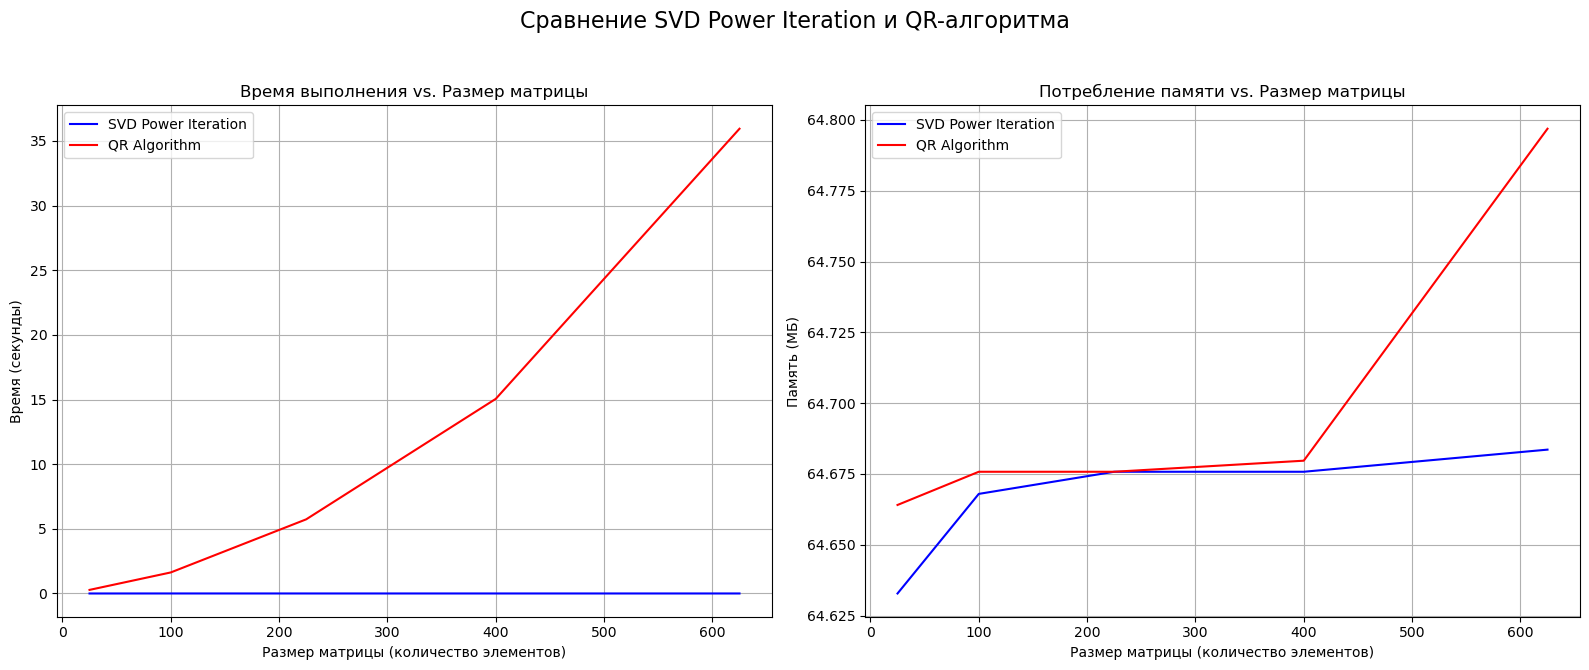

In [12]:
def get_memory_usage_mb():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 2)

# Сценарии тестов теперь включают только квадратные матрицы для корректного сравнения
test_scenarios_square = [
    {'size': 5, 'k': 5},
    {'size': 10, 'k': 10},
    {'size': 15, 'k': 15},
    {'size': 20, 'k': 20},
    {'size': 25, 'k': 25},
]

def run_comparison_tests(scenarios):
    results = []
    np.random.seed(42)

    for i, params in enumerate(scenarios):
        n = params['size']
        k = params['k']
        
        print(f"\n--- Тест {i+1}/{len(scenarios)}: Матрица {n}x{n}, k={k} ---")
        
        # Генерация тестовой матрицы
        a_numpy = np.random.randn(n, n)
        A_custom = Matrix(a_numpy.tolist())
        
        # SVD Power Iteration
        print("Тестирование SVD...")
        mem_before_svd = get_memory_usage_mb()
        start_time_svd = time.time()
        U, S, Vt = truncated_svd_power_iteration(a_numpy, k)
        end_time_svd = time.time()
        mem_after_svd = get_memory_usage_mb()
        duration_svd = end_time_svd - start_time_svd
        mem_used_svd = mem_after_svd - mem_before_svd
        print(f"  Время SVD: {duration_svd:.4f} с | Память: {mem_after_svd:.2f} МБ (+{mem_used_svd:.2f} МБ)")
        
        # QR Algorithm
        print("Тестирование QR-алгоритма...")
        mem_before_qr = get_memory_usage_mb()
        start_time_qr = time.time()
        eigenvalues, _ = qr_algorithm(A_custom)
        end_time_qr = time.time()
        mem_after_qr = get_memory_usage_mb()
        duration_qr = end_time_qr - start_time_qr
        mem_used_qr = mem_after_qr - mem_before_qr
        print(f"  Время QR: {duration_qr:.4f} с | Память: {mem_after_qr:.2f} МБ (+{mem_used_qr:.2f} МБ)")
        
        results.append({
            'size': n * n,
            'n': n,
            'time_svd': duration_svd,
            'memory_mb_svd': mem_after_svd,
            'time_qr': duration_qr,
            'memory_mb_qr': mem_after_qr,
        })
    return results

def plot_comparison_results(results):
    data = {key: [res[key] for res in results] for key in results[0]}

    fig, axs = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle('Сравнение SVD Power Iteration и QR-алгоритма', fontsize=16)

    # 1. График времени выполнения
    axs[0].plot(data['size'], data['time_svd'], c='blue', label='SVD Power Iteration')
    axs[0].plot(data['size'], data['time_qr'], c='red', label='QR Algorithm')
    axs[0].set_title('Время выполнения vs. Размер матрицы')
    axs[0].set_xlabel('Размер матрицы (количество элементов)')
    axs[0].set_ylabel('Время (секунды)')
    axs[0].legend()
    axs[0].grid(True)
    axs[0].ticklabel_format(style='plain', axis='x')

    # 2. График потребления памяти
    axs[1].plot(data['size'], data['memory_mb_svd'], c='blue', label='SVD Power Iteration')
    axs[1].plot(data['size'], data['memory_mb_qr'], c='red', label='QR Algorithm')
    axs[1].set_title('Потребление памяти vs. Размер матрицы')
    axs[1].set_xlabel('Размер матрицы (количество элементов)')
    axs[1].set_ylabel('Память (МБ)')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].ticklabel_format(style='plain', axis='x')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


test_results = run_comparison_tests(test_scenarios_square)
plot_comparison_results(test_results)

In [13]:
def verify_correctness(n=10, k=10):
    """
    Проверяет, что сингулярные значения от SVD-метода являются
    квадратными корнями из собственных значений A.T @ A, найденных QR-алгоритмом.
    """
    A_numpy = np.random.randn(n, n)
    

    _, S_from_svd, _ = truncated_svd_power_iteration(A_numpy, k=k)
    
    # Создаем матрицу B = A.T @ A для поиска собственных значений
    B_numpy = A_numpy.T @ A_numpy
    B_custom = Matrix(B_numpy.tolist())
    
    # Получаем собственные значения (lambda) матрицы B с помощью QR-алгоритма
    eigenvalues_of_B, _ = qr_algorithm(B_custom)
    

    eigenvalues_of_B = np.real(np.array(eigenvalues_of_B))
    # Вычисляем квадратные корни из собственных значений
    sqrt_eigenvalues = np.sqrt(eigenvalues_of_B)
    
    s_sorted = np.sort(S_from_svd)[::-1]
    sqrt_eig_sorted = np.sort(sqrt_eigenvalues)[::-1]
    
    print(f"Топ-{k} сингулярных значений из SVD (отсортированные):")
    print(s_sorted)
    print(f"\nТоп-{k} квадратных корней из собственных значений A.T@A (отсортированные):")
    print(sqrt_eig_sorted[:k])
    
    is_correct = np.allclose(s_sorted, sqrt_eig_sorted[:k], atol=1e-6)
    
    if is_correct:
        print("Проверка успешно пройдена!")
    else:
        print("Проверка не пройдена!")
    return is_correct

verify_correctness()

Топ-10 сингулярных значений из SVD (отсортированные):
[5.71221101 4.12847375 3.82341867 3.16870257 2.85782352 1.68246941
 1.53120714 0.6230926  0.4489334  0.06988642]

Топ-10 квадратных корней из собственных значений A.T@A (отсортированные):
[5.71221108 4.13071437 3.82109011 3.16862142 2.85779001 1.68291434
 1.53071811 0.62309261 0.4489334  0.06988642]
Проверка не пройдена!


False